# Import dependencies

In [90]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# Load datasets and extract images

In [91]:
dataset = np.load('../Datasets/pneumoniamnist.npz')
print("dataset keys: ", pd.DataFrame(dataset).head())

# extract images
train_images = dataset['train_images']
val_images = dataset['val_images']
test_images = dataset['test_images']

# extract labels
train_labels = dataset['train_labels']
val_labels = dataset['val_labels']
test_labels = dataset['test_labels']

dataset keys:                0
0  train_images
1    val_images
2   test_images
3  train_labels
4    val_labels


# Get image dimensions

In [92]:
train_images_shape = np.shape(train_images)
train_labels_shape = np.shape(train_labels)
val_images_shape = np.shape(val_images)
val_labels_shape = np.shape(val_labels)
test_images_shape = np.shape(test_images)
test_labels_shape = np.shape(test_labels)

print("train_images_shape: ", train_images_shape)
print("train_labels_shape: ", train_labels_shape)
print("val_images_shape: ", val_images_shape)
print("val_labels_shape: ", val_labels_shape)
print("test_images_shape: ", test_images_shape)
print("test_labels_shape: ", test_labels_shape)

train_images_shape:  (4708, 28, 28)
train_labels_shape:  (4708, 1)
val_images_shape:  (524, 28, 28)
val_labels_shape:  (524, 1)
test_images_shape:  (624, 28, 28)
test_labels_shape:  (624, 1)


# Visualising images
1 is positive, 0 is negative (for pneumonia)

Test Image, case:  [1]


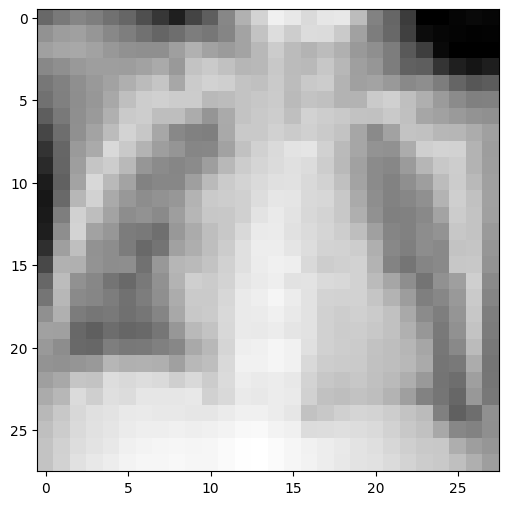

Test Image, case:  [1]


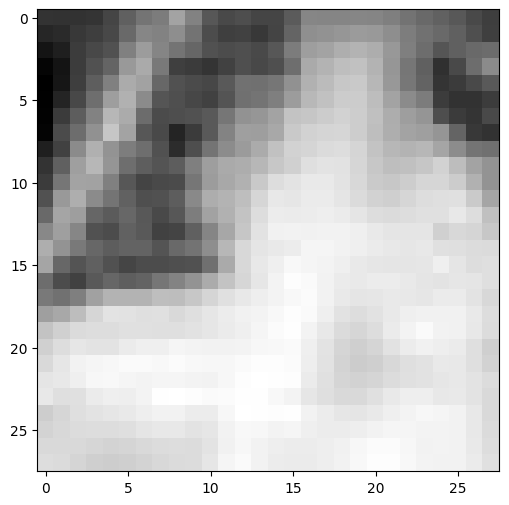

In [93]:
# 0 case
test_image = train_images[0]
test_image_label = train_labels[0]
# print('Test Image as array: ', test_image)
print('Test Image, case: ', test_image_label)
# Visualizing the same image
plt.figure(figsize=(6, 6))
plt.imshow(test_image, cmap='gray') 
plt.show()

# 1 case
test_image_1 = train_images[-1]
test_image_label_1 = train_labels[-1]
print('Test Image, case: ', test_image_label_1)
# Visualizing the same image
plt.figure(figsize=(6, 6))
plt.imshow(test_image_1, cmap='gray') 
plt.show()

# Normalize images to floating point, convert labels, and expand images to fit grey scale channel


In [94]:
# normalize images
train_images_norm = train_images.astype('float32') / 255
val_images_norm = val_images.astype('float32') / 255
test_images_norm = test_images.astype('float32') / 255

# convert labels
train_labels_conv = tf.keras.utils.to_categorical(train_labels)
val_labels_conv = tf.keras.utils.to_categorical(val_labels)
test_labels_conv = tf.keras.utils.to_categorical(test_labels)

# expand image shape
train_images_exp = np.expand_dims(train_images_norm, axis=-1)  # Add an extra dimension for the channel
val_images_exp = np.expand_dims(val_images_norm, axis=-1)
test_images_exp = np.expand_dims(test_images_norm, axis=-1)

# see new shapes
train_images_shape_new = np.shape(train_images_exp)
train_labels_shape_new = np.shape(train_labels_conv)
val_images_shape_new = np.shape(val_images_exp)
val_labels_shape_new = np.shape(val_labels_conv)
test_images_shape_new = np.shape(test_images_exp)
test_labels_shape_new = np.shape(test_labels_conv)

print("train_images_shape: ", train_images_shape_new)
print("train_labels_shape: ", train_labels_shape_new)
print("val_images_shape: ", val_images_shape_new)
print("val_labels_shape: ", val_labels_shape_new)
print("test_images_shape: ", test_images_shape_new)
print("test_labels_shape: ", test_labels_shape_new)

train_images_shape:  (4708, 28, 28, 1)
train_labels_shape:  (4708, 2)
val_images_shape:  (524, 28, 28, 1)
val_labels_shape:  (524, 2)
test_images_shape:  (624, 28, 28, 1)
test_labels_shape:  (624, 2)


# Create CNN model


In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=train_images_exp.shape[1:]),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(test_labels_conv[0]), activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1600)              0         
                                                                 
 dense_20 (Dense)            (None, 64)              

# Train model

In [96]:
history = model.fit(train_images_exp, train_labels_conv, epochs=30, validation_data=(val_images_exp, val_labels_conv))


Epoch 1/30
148/148 [==============================] - 1s 7ms/step - loss: 0.3424 - accuracy: 0.8456 - val_loss: 0.1864 - val_accuracy: 0.9198
Epoch 2/30
148/148 [==============================] - 1s 6ms/step - loss: 0.1716 - accuracy: 0.9314 - val_loss: 0.1430 - val_accuracy: 0.9542
Epoch 3/30
148/148 [==============================] - 1s 6ms/step - loss: 0.1408 - accuracy: 0.9471 - val_loss: 0.1270 - val_accuracy: 0.9599
Epoch 4/30
148/148 [==============================] - 1s 6ms/step - loss: 0.1233 - accuracy: 0.9539 - val_loss: 0.1077 - val_accuracy: 0.9599
Epoch 5/30
148/148 [==============================] - 1s 6ms/step - loss: 0.1143 - accuracy: 0.9531 - val_loss: 0.1188 - val_accuracy: 0.9561
Epoch 6/30
148/148 [==============================] - 1s 6ms/step - loss: 0.1236 - accuracy: 0.9518 - val_loss: 0.1072 - val_accuracy: 0.9542
Epoch 7/30
148/148 [==============================] - 1s 6ms/step - loss: 0.0958 - accuracy: 0.9637 - val_loss: 0.0829 - val_accuracy: 0.9714
Epoch 

# Plot training performance

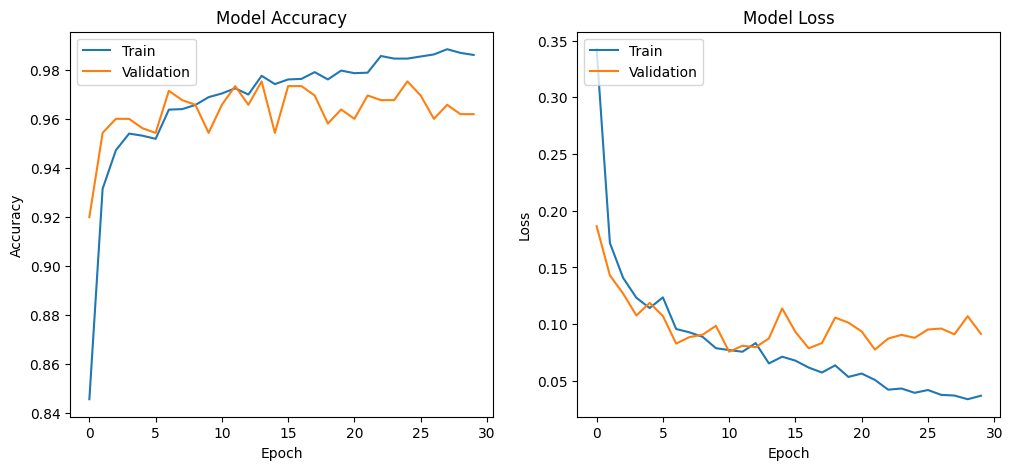

In [97]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Analyse test accuracy w/ Confusion matrix

20/20 [==============================] - 0s 2ms/step - loss: 0.7999 - accuracy: 0.8446
Test accuracy: 0.8445512652397156
20/20 [==============================] - 0s 2ms/step


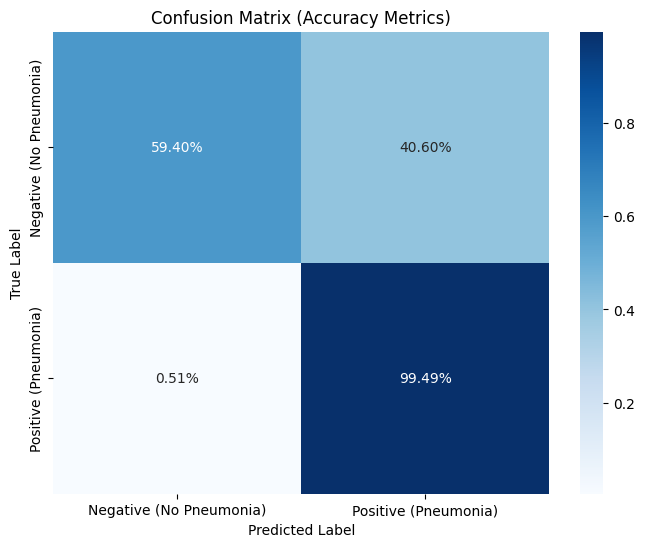

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(test_images_exp, test_labels_conv)
print("Test accuracy:", test_acc)

predicted_classes = np.argmax(model.predict(test_images_exp), axis=1)
true_classes = np.argmax(test_labels_conv, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

TN_rate = TN / (TN + FP)
FP_rate = FP / (TN + FP)
FN_rate = FN / (TP + FN)
TP_rate = TP / (TP + FN)

cm_normalized = np.array([[TN_rate, FP_rate], [FN_rate, TP_rate]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'], yticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Accuracy Metrics)')
plt.show()

In [99]:
# Save the model
model.save("task_a_basic_model_81")

INFO:tensorflow:Assets written to: task_a_basic_model_81/assets


INFO:tensorflow:Assets written to: task_a_basic_model_81/assets


# Analyse Error Images

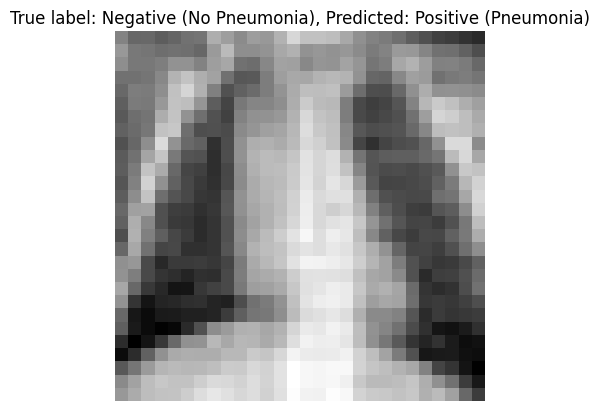

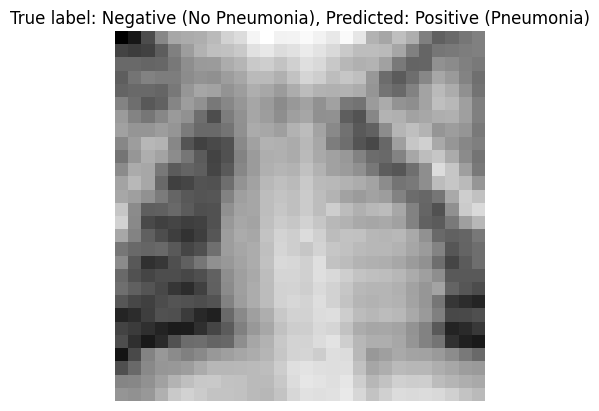

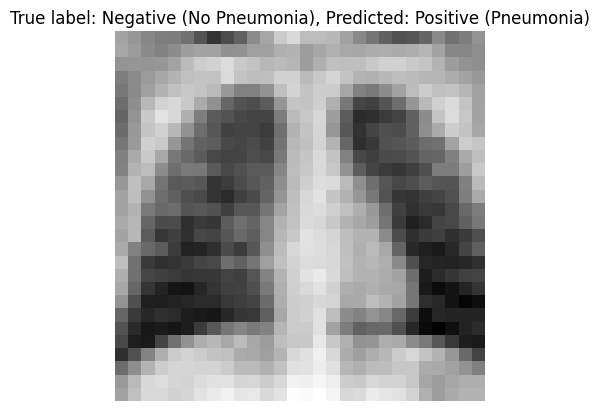

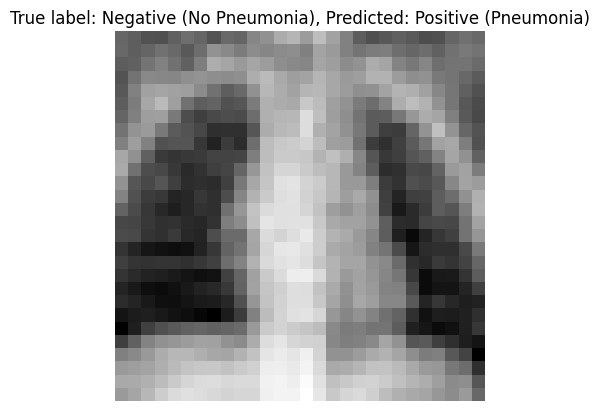

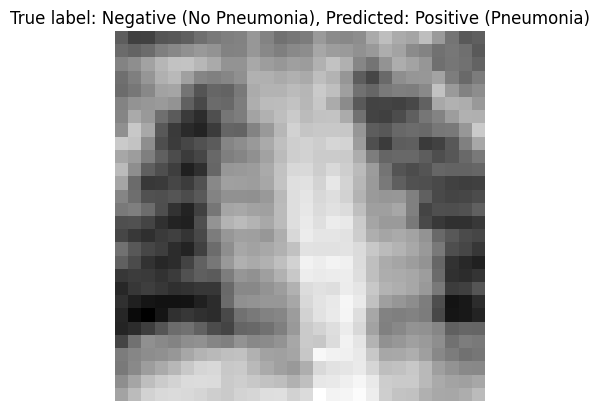

In [100]:
def label_to_string(label):
    return "Positive (Pneumonia)" if label == 1 else "Negative (No Pneumonia)"

misclassified_indices = np.where(predicted_classes != true_classes)[0]
sample_misclassified_indices = np.random.choice(misclassified_indices, 5, replace=False)

for i in sample_misclassified_indices:
    plt.imshow(test_images_exp[i].reshape(28, 28), cmap='gray')
    true_label_str = label_to_string(true_classes[i])
    predicted_label_str = label_to_string(predicted_classes[i])
    plt.title(f"True label: {true_label_str}, Predicted: {predicted_label_str}")
    plt.axis('off')
    plt.show()

# Analyse Distribution of data

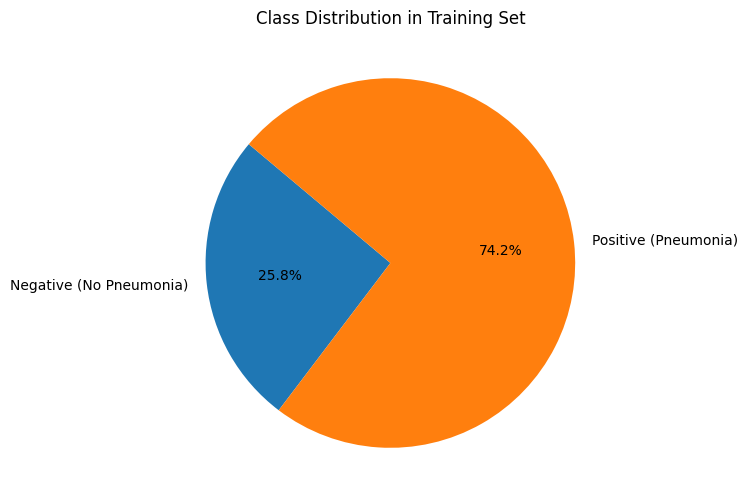

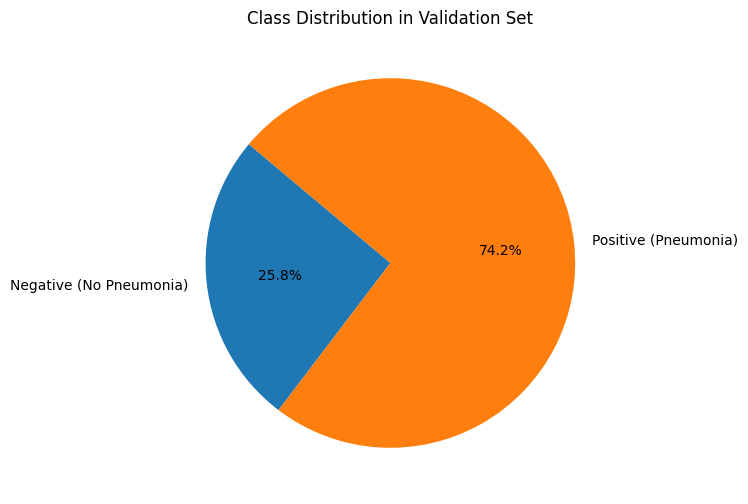

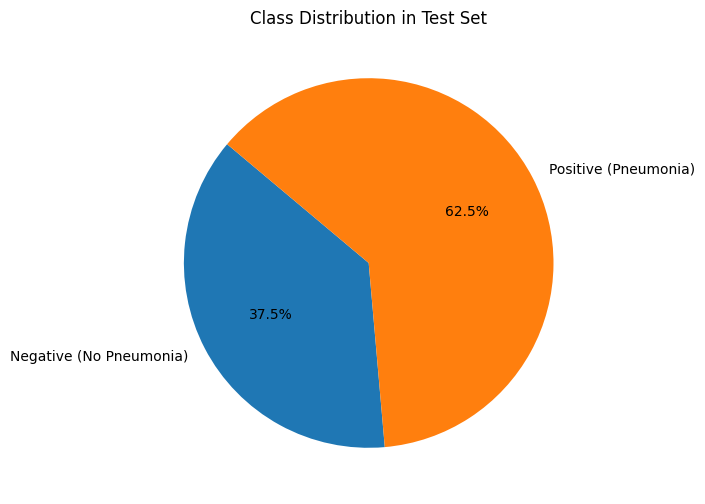

training count [1214. 3494.]


In [101]:
def plot_class_distribution(labels, dataset_name):
    class_counts = np.sum(labels, axis=0)
    class_labels = ['Negative (No Pneumonia)', 'Positive (Pneumonia)']

    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.show()
    return class_counts 

# Plot distribution for each dataset
train_count = plot_class_distribution(train_labels_conv, "Training")
val_count = plot_class_distribution(val_labels_conv, "Validation")
test_count = plot_class_distribution(test_labels_conv, "Test")
print("training count", train_count)


# Augmenting new data
From analysing the results, it can be seen that the model underperforms when it comes to predicting negative class and also overfits. We can try data augmentation to try and balance the classes and reduce overfitting on the postive classes.

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import math

# # get counts for negative and positive classes
negative_train_count = train_count[0]
positive_train_count = train_count[1]
# calc how much augmented data is needed
total_synthetic_needed = positive_train_count - negative_train_count
augment_per_image = math.ceil(total_synthetic_needed / negative_train_count)

# Identifying indices of the negative class
negative_class_indices = np.where(np.argmax(train_labels_conv, axis=1) == 0)[0]

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
)

augmented_images = []
augmented_labels = []

for i in negative_class_indices:
    img = train_images_exp[i].reshape((1,) + train_images_exp[i].shape)
    generated_count = 0
    for x in datagen.flow(img, batch_size=1):
        augmented_images.append(x[0])
        augmented_labels.append(train_labels_conv[i])
        generated_count += 1
        if generated_count >= augment_per_image:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine with original training data
train_images_balanced = np.concatenate((train_images_exp, augmented_images))
train_labels_balanced = np.concatenate((train_labels_conv, augmented_labels))
train_images_balanced, train_labels_balanced = shuffle(train_images_balanced, train_labels_balanced)

# Compare original with augmented images

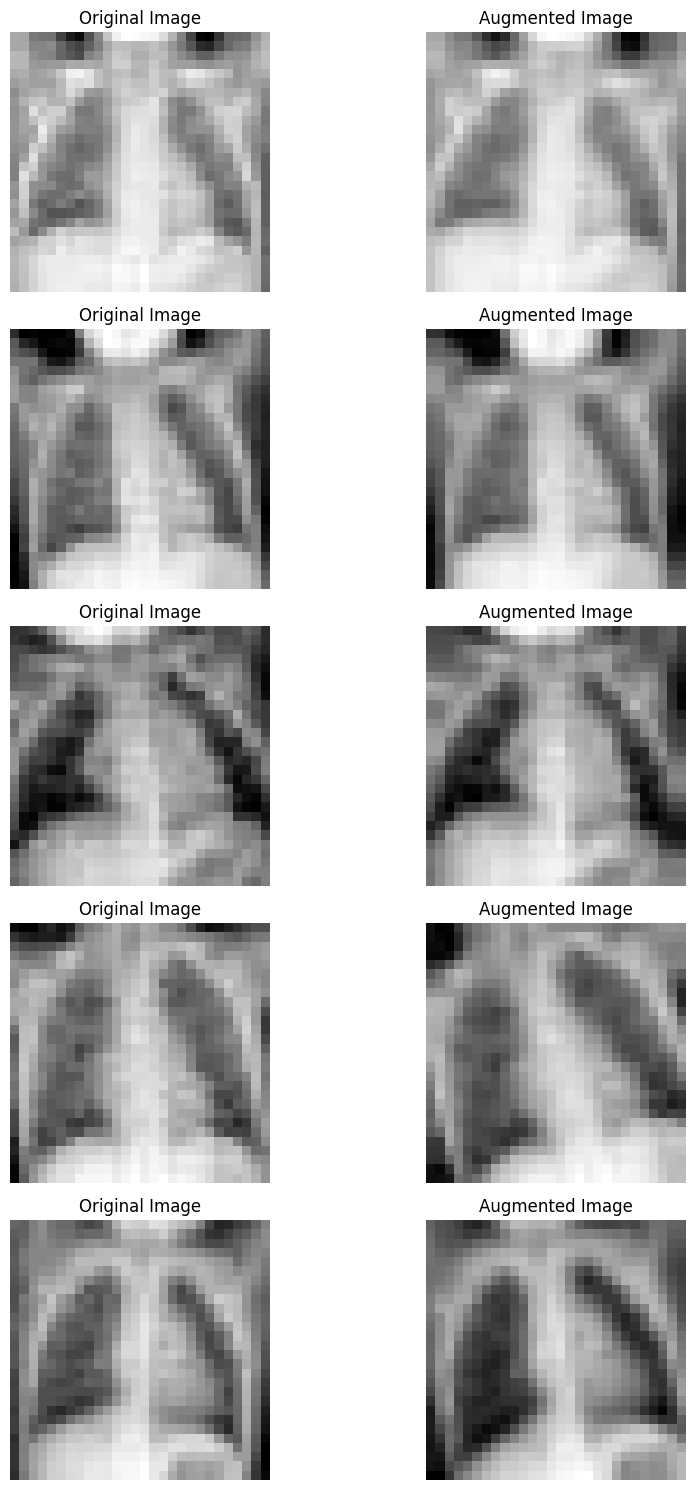

In [103]:
# Choose a small number of original images to display
num_images_to_display = 5  

# Set up a plot
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, num_images_to_display * 3))

# Select random indices from the negative class
sample_indices = np.random.choice(negative_class_indices, num_images_to_display, replace=False)

for i, idx in enumerate(sample_indices):
    # Display original image
    axes[i, 0].imshow(train_images_exp[idx].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')
    
    # Generate and display one augmented image
    img = train_images_exp[idx].reshape((1,) + train_images_exp[idx].shape)
    for x in datagen.flow(img, batch_size=1):
        axes[i, 1].imshow(x[0].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis('off')
        break  # Only generate one augmented image for comparison

plt.tight_layout()
plt.show()

# New distribution of training data

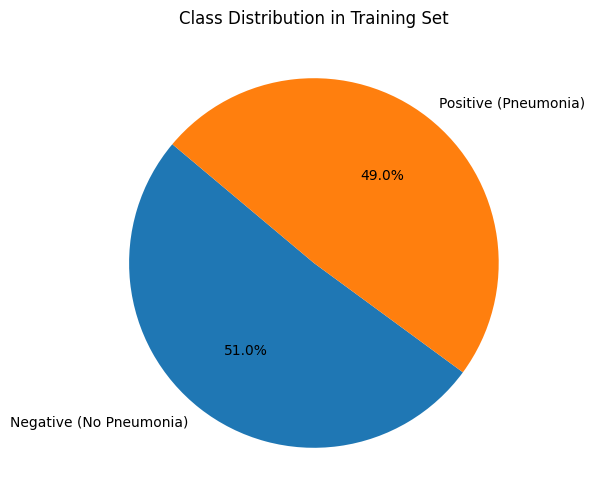

[3642. 3494.]


In [104]:
train_count_balanced = plot_class_distribution(train_labels_balanced, "Training")
print(train_count_balanced)

# Recreate and analyse the model using the new balanced training dataset

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the L2 regularization factor
l2_reg = 0.001

model_balanced = Sequential([
    # First Convolutional Block with L2 Regularization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg), input_shape=train_images_balanced.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block with L2 Regularization
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flattening to a single vector
    Flatten(),

    # Dense Layer with L2 Regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),

    # Output Layer
    Dense(len(test_labels_conv[0]), activation='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_balanced.compile(optimizer="adam",  loss='categorical_crossentropy',
                metrics=['accuracy'])


# Train new model

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with early stopping
history_balanced = model_balanced.fit(
    train_images_balanced, 
    train_labels_balanced, 
    epochs=30,
    validation_data=(val_images_exp, val_labels_conv),
    callbacks=[early_stopping]
)

Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.5367 - accuracy: 0.7843 - val_loss: 0.5425 - val_accuracy: 0.7672
Epoch 2/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3420 - accuracy: 0.8941 - val_loss: 0.3537 - val_accuracy: 0.8683
Epoch 3/30
223/223 [==============================] - 1s 6ms/step - loss: 0.3119 - accuracy: 0.9057 - val_loss: 0.3501 - val_accuracy: 0.8588
Epoch 4/30
223/223 [==============================] - 1s 6ms/step - loss: 0.2886 - accuracy: 0.9154 - val_loss: 0.2758 - val_accuracy: 0.9122
Epoch 5/30
223/223 [==============================] - 1s 6ms/step - loss: 0.2627 - accuracy: 0.9250 - val_loss: 0.2020 - val_accuracy: 0.9408
Epoch 6/30
223/223 [==============================] - 1s 6ms/step - loss: 0.2565 - accuracy: 0.9278 - val_loss: 0.1921 - val_accuracy: 0.9504
Epoch 7/30
223/223 [==============================] - 1s 6ms/step - loss: 0.2434 - accuracy: 0.9302 - val_loss: 0.1793 - val_accuracy: 0.9561
Epoch 

# Analyse new model

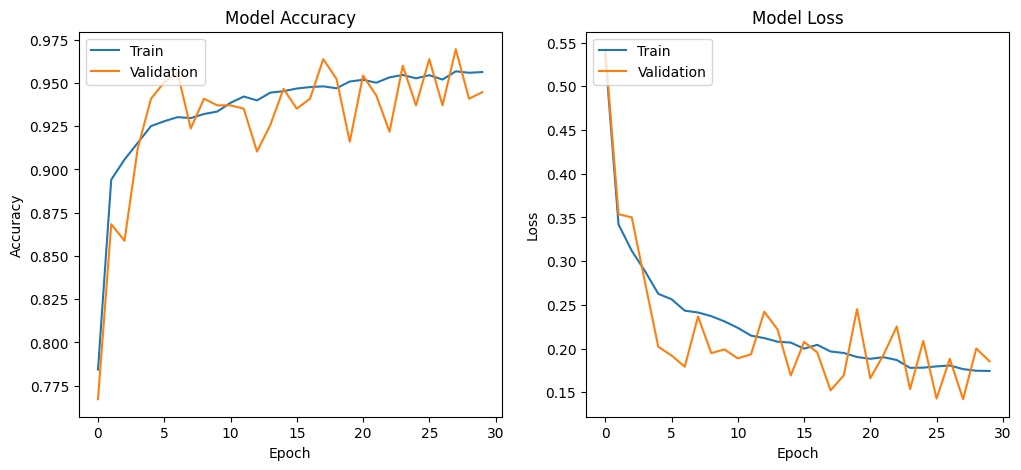

In [117]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['accuracy'])
plt.plot(history_balanced.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['loss'])
plt.plot(history_balanced.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


20/20 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.9054
Test accuracy balanced: 0.9054487347602844
20/20 [==============================] - 0s 2ms/step


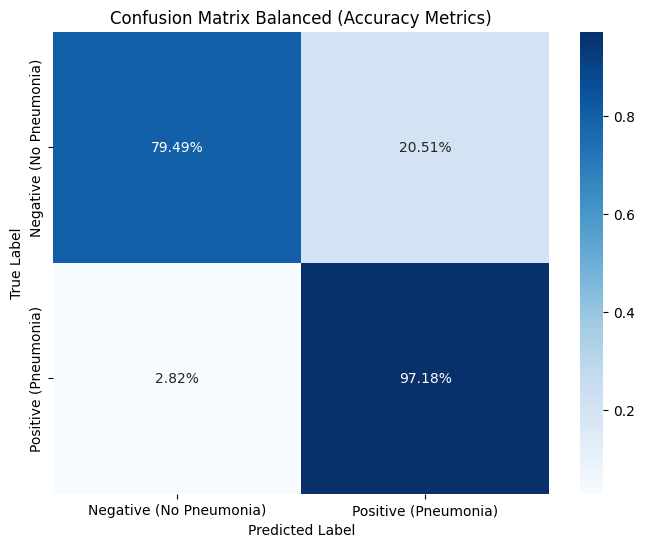

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss_balanced, test_acc_balanced = model_balanced.evaluate(test_images_exp, test_labels_conv)
print("Test accuracy balanced:", test_acc_balanced)

predicted_classes_balanced = np.argmax(model_balanced.predict(test_images_exp), axis=1)
true_classes_balanced = np.argmax(test_labels_conv, axis=1)

cm_balanced = confusion_matrix(true_classes_balanced, predicted_classes_balanced)

balanced_TN = cm_balanced[0, 0]
balanced_FP = cm_balanced[0, 1]
balanced_FN = cm_balanced[1, 0]
balanced_TP = cm_balanced[1, 1]

balanced_TN_rate = balanced_TN / (balanced_TN + balanced_FP)
balanced_FP_rate = balanced_FP / (balanced_TN + balanced_FP)
balanced_FN_rate = balanced_FN / (balanced_TP + balanced_FN)
balanced_TP_rate = balanced_TP / (balanced_TP + balanced_FN)

cm_normalized_balanced = np.array([[balanced_TN_rate, balanced_FP_rate], [balanced_FN_rate, balanced_TP_rate]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_balanced, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'], yticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Balanced (Accuracy Metrics)')
plt.show()

In [119]:
# save model 
model_balanced.save("balanced_model_90")

INFO:tensorflow:Assets written to: balanced_model_90/assets


INFO:tensorflow:Assets written to: balanced_model_90/assets
